# Importing libraries

In [62]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
import linearmodels.panel
from sklearn.preprocessing import LabelEncoder, StandardScaler
import causallearn.search.ConstraintBased.PC
import dowhy
import collections
from functools import reduce

In [3]:
pd.set_option('display.max_columns', None)

# Importing dataset

In [4]:
# Reading raw data
path_1 = r'..\Raw data\Aaklan_rawdata.csv'
df_1 = pd.read_csv(path_1)

# Setting up datetime column
df_1['timestamp'] = df_1['timestamp'].map(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
df_1['day'] = df_1['timestamp'].apply(lambda x: x.day)
df_1['month'] = df_1['timestamp'].apply(lambda x: x.month)
df_1['year'] = df_1['timestamp'].apply(lambda x: x.year)
df_1['date'] = df_1['timestamp'].apply(lambda x: datetime.date(x))
df_1 = df_1.drop(labels = 'timestamp', axis = 1)

# Calculating total scores
df_1['total_A2'] = df_1.iloc[:,4:11].sum(axis = 1)
df_1['total_A1'] = df_1.iloc[:,18:25].sum(axis = 1)

# Declaring stirng variables
df_1['district'] = df_1['district'].apply(lambda x: str(x).lower().strip())

In [5]:
# Reading district data
path_2 = r'..\Raw data\District_data.csv'
df_2 = pd.read_csv(path_2)

# Declaring string variables
df_2['district'] = df_2['district'].apply(lambda x: str(x).lower().strip())

In [6]:
df_1.head()

,batch,name,ph_no,district,A2_Q1_R/W,A2_Q2_R/W,A2_Q3_R/W,A2_Q4_R/W,A2_Q5_R/W,A2_Q6_R/W,A2_Q7_R/W,A2_Q1_Abs,A2_Q2_Abs,A2_Q3_Abs,A2_Q4_Abs,A2_Q5_Abs,A2_Q6_Abs,A2_Q7_Abs,A1_Q1_R/W,A1_Q2_R/W,A1_Q3_R/W,A1_Q4_R/W,A1_Q5_R/W,A1_Q6_R/W,A1_Q7_R/W,A1_Q1_Abs,A1_Q2_Abs,A1_Q3_Abs,A1_Q4_Abs,A1_Q5_Abs,A1_Q6_Abs,A1_Q7_Abs,day,month,year,date,total_A2,total_A1
0,Agra_10_12,vs_1,6397387939,agra,0,1,0,0,1,1,0,3,2,2,1,3,1,3,0,1,1,0,1,1,1,3,2,1,4,3,1,1,10,12,2024,2024-12-10,3,5
1,Agra_10_12,vs_2,6398905390,agra,1,1,1,0,1,1,0,1,2,1,1,3,1,3,1,1,1,0,1,1,1,1,2,1,1,3,1,1,10,12,2024,2024-12-10,5,6
2,Agra_10_12,vs_3,7078958291,agra,1,0,0,0,1,1,1,1,1,4,1,3,1,1,1,0,0,0,0,1,0,1,1,4,4,1,1,3,10,12,2024,2024-12-10,4,2
3,Agra_10_12,vs_4,7302305427,agra,1,0,1,0,1,1,1,1,1,1,1,3,1,1,0,0,1,1,1,1,0,2,1,1,3,3,1,2,10,12,2024,2024-12-10,5,4
4,Agra_10_12,vs_5,7505846632,agra,1,1,1,0,1,1,0,1,2,1,1,3,1,3,1,1,1,0,1,1,0,1,2,1,1,3,1,3,10,12,2024,2024-12-10,5,5


In [7]:
df_2.head()

,district,Number of Vidyut Sakhis Trained,DRP Presence,DMM Presence,N-BMM Presence,DISCOM officials presence,DMM First Phase Presence,Commission/VS_INR,Average Bill Amount_INR,Number of VS working,Percent_Training Target Achieved,DISCOM
0,agra,155,1,1,1,0,1,47552,2359,69,0.80,DVVNL
1,aligarh,186,0,1,1,0,0,13135,1321,94,0.89,DVVNL
2,ambedkar nagar,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL
3,amethi,104,0,1,1,0,1,26859,1943,119,0.93,MVVNL
4,amroha,27,0,1,1,0,1,7804,5395,93,0.77,PVVNL


In [8]:
a = df_1['district'].unique()
b = df_2['district'].unique()

# Cleaning

In [77]:
# Identifying response strings
df_1['A2_string'] = df_1.loc[:, 'A2_Q1_Abs': 'A2_Q7_Abs'].astype(str).sum(axis = 1)
df_1['A1_string'] = df_1.loc[:, 'A1_Q1_Abs': 'A1_Q7_Abs'].astype(str).sum(axis = 1)

In [99]:
# Counting number of duplicates of max occuring string
a1_dup = df_1.groupby('batch')['A1_string'].apply(lambda x: max(collections.Counter(x).values())*100/x.shape[0]).round(0).sort_values()
a2_dup = df_1.groupby('batch')['A2_string'].apply(lambda x: max(collections.Counter(x).values())*100/x.shape[0]).round(0).sort_values()

# Batch size
batch_size = df_1.groupby('batch').size().sort_values()

# Batch wise cheating data
batch_df = pd.concat([a1_dup, a2_dup, batch_size], axis = 1)
batch_df.columns = ['A1_duplicate_percent', 'A2_duplicate_percent', 'batch_size']
batch_df = batch_df.sort_values(by = ['batch_size', 'A1_duplicate_percent', 'A2_duplicate_percent'])

# Removing large batches(more than 10 VS) with potential of cheating (95% or more VS with same answers)
rm_batch_list = np.unique(batch_df[(batch_df['batch_size']>=10) & (batch_df['A1_duplicate_percent']>=95)].index.to_list()           # Batches with cheating in Aaklan-1
                            + batch_df[(batch_df['batch_size']>=10) & (batch_df['A2_duplicate_percent']>=95)].index.to_list())      # Batches with cheating in Aaklan-2

# Descriptive statistics

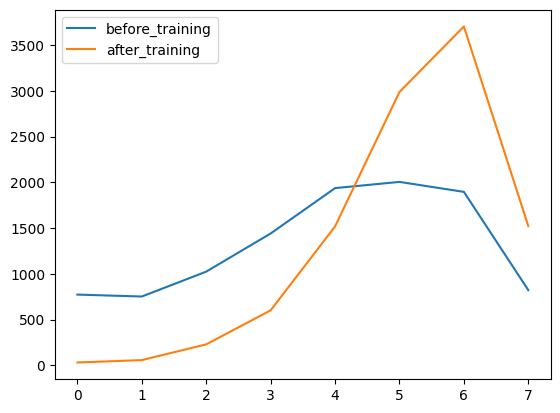

In [ ]:
plt.plot(df_1['total_A1'].value_counts().sort_index(),label = 'before_training')
plt.plot(df_1['total_A2'].value_counts().sort_index(),label = 'after_training')
plt.legend()

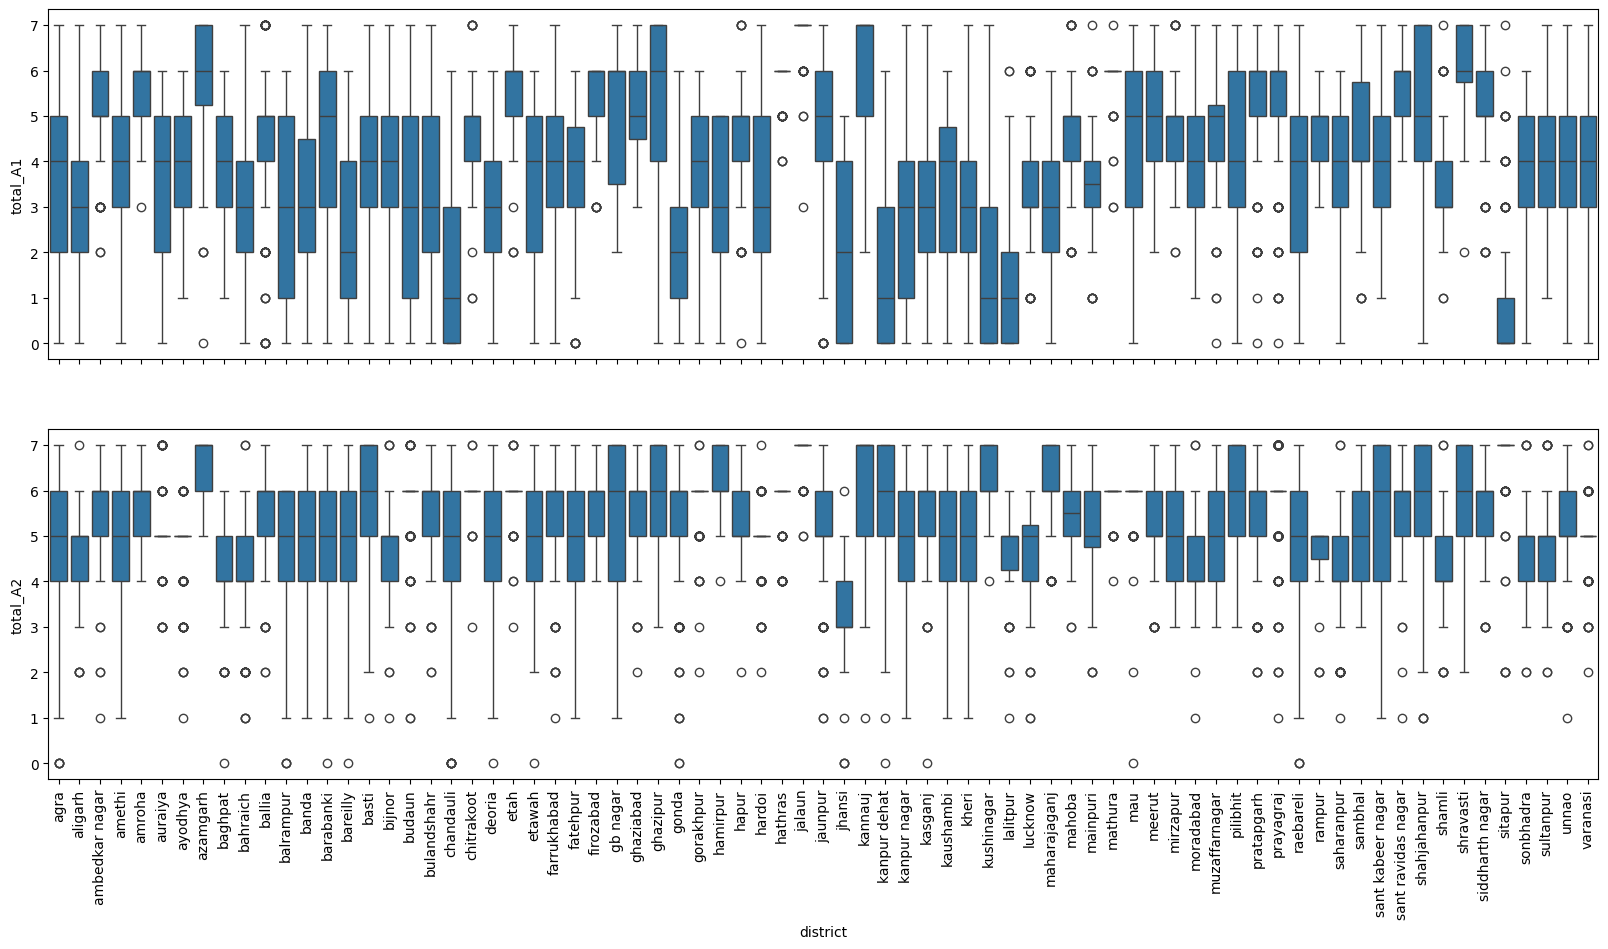

Some districts have no variation at all. This data needs cleaning


In [9]:
# Plotting district wise distribution of scores
fig, axs = plt.subplots(nrows = 2, figsize = (20,10), sharex=True)
sns.boxplot(data = df_1, x = 'district', y = 'total_A1', ax = axs[0])
sns.boxplot(data = df_1, x = 'district', y = 'total_A2', ax = axs[1])
plt.xticks(rotation = 90)
plt.show()
print("Some districts have no variation at all. This data needs cleaning")


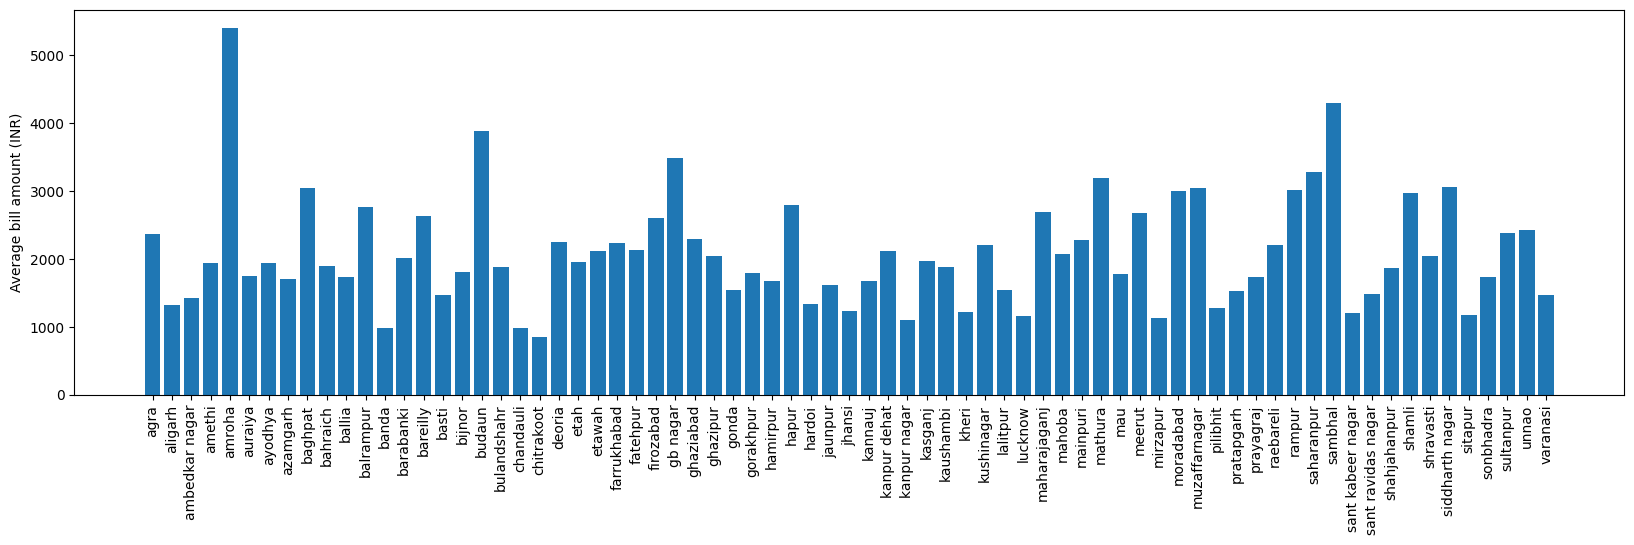

In [10]:
# Plotting variation in district wise bill amount
plt.figure(figsize=(20,5))
plt.bar(x = df_2['district'].values, height = df_2['Average Bill Amount_INR'].values)
plt.xticks(rotation = 90)
plt.ylabel("Average bill amount (INR)")
plt.show()

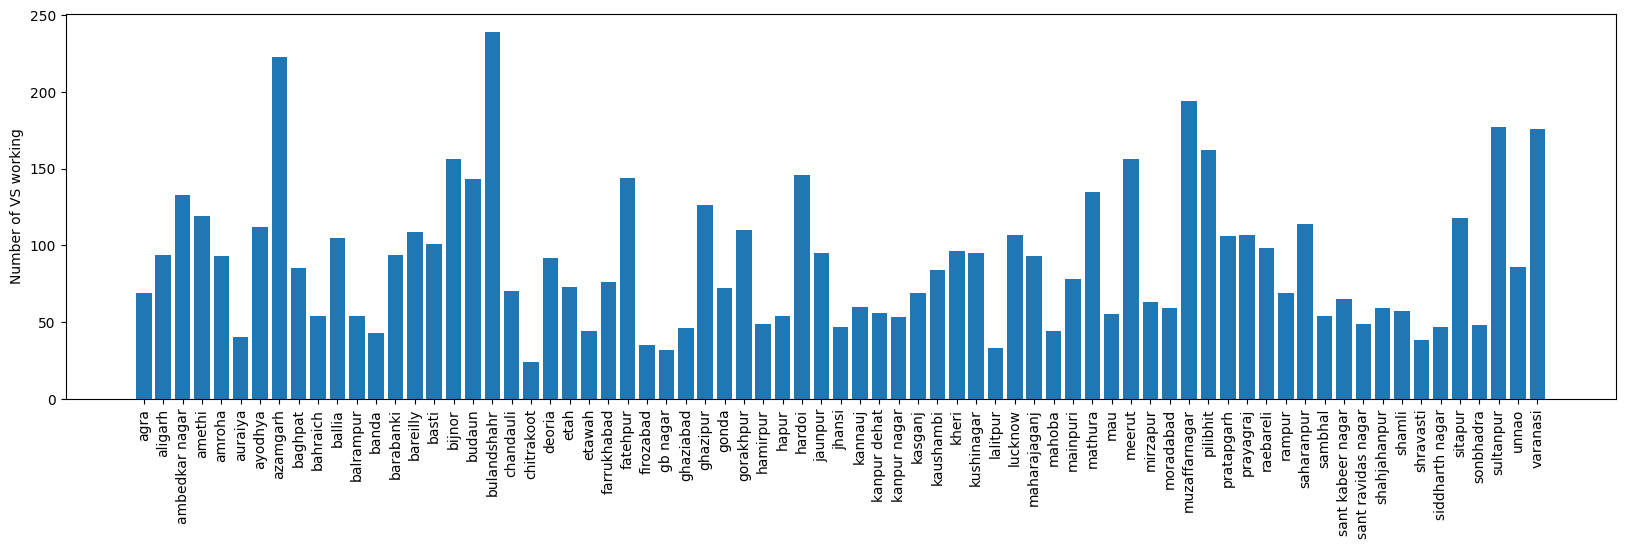

In [11]:
# Plotting variation in district wise number of VS working
plt.figure(figsize=(20,5))
plt.bar(x = df_2['district'].values, height = df_2['Number of VS working'].values)
plt.xticks(rotation = 90)
plt.ylabel("Number of VS working")
plt.show()

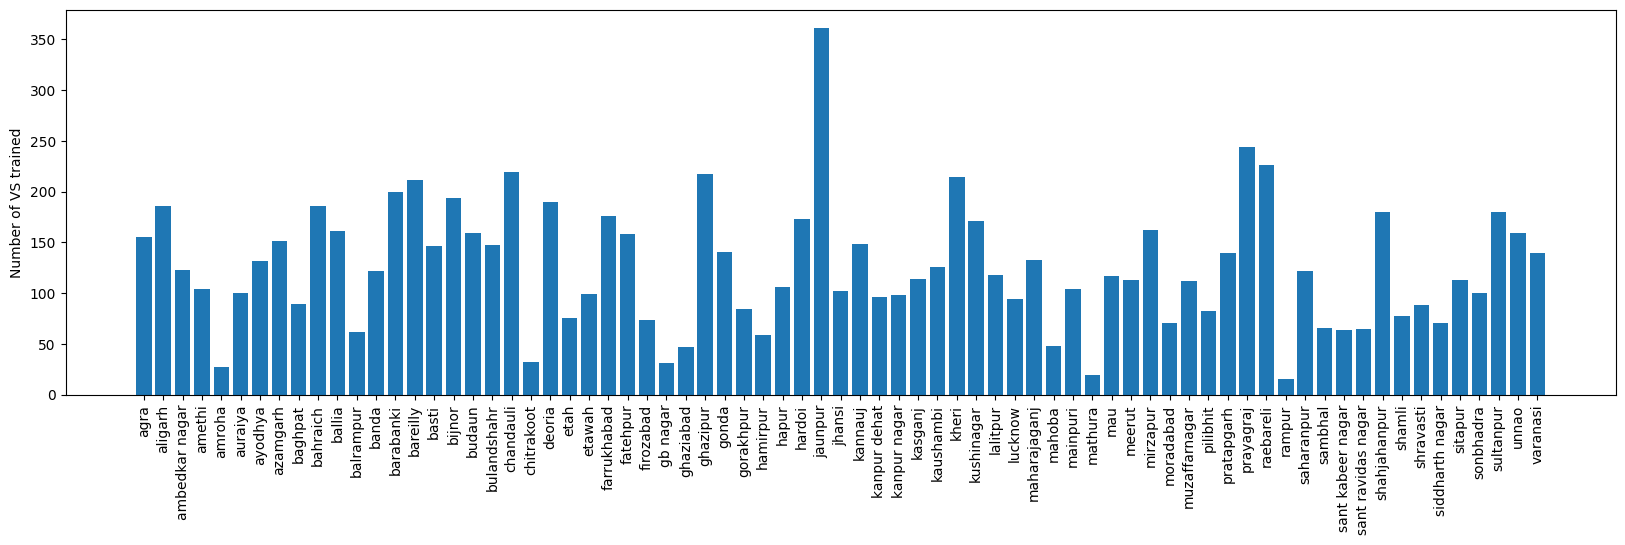

In [12]:
# Plotting variation in district wise number of VS trained
plt.figure(figsize=(20,5))
plt.bar(x = df_2['district'].values, height = df_2['Number of Vidyut Sakhis Trained'].values)
plt.xticks(rotation = 90)
plt.ylabel("Number of VS trained")
plt.show()

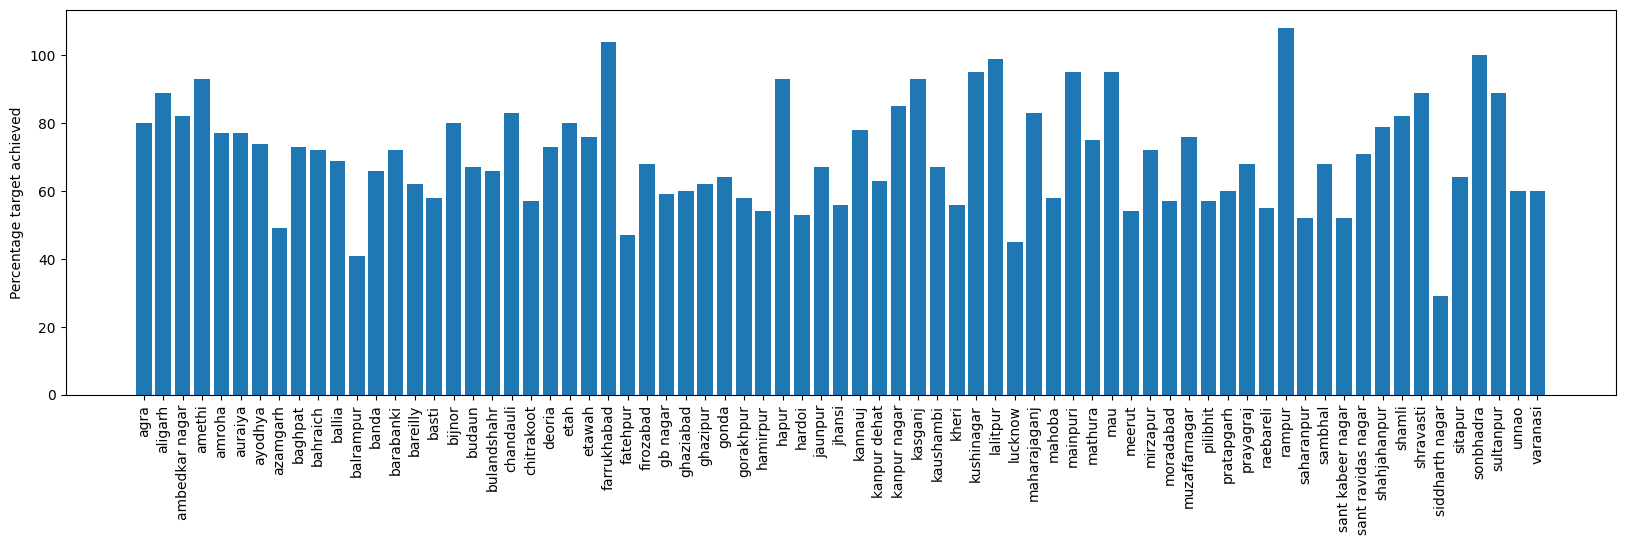

In [13]:
# Plotting variation in district wise percentage training achieved
plt.figure(figsize=(20,5))
plt.bar(x = df_2['district'].values, height = df_2['Percent_Training Target Achieved'].values*100)
plt.xticks(rotation = 90)
plt.ylabel("Percentage target achieved")
plt.show()

<Axes: xlabel='DISCOM', ylabel='Number of Vidyut Sakhis Trained'>

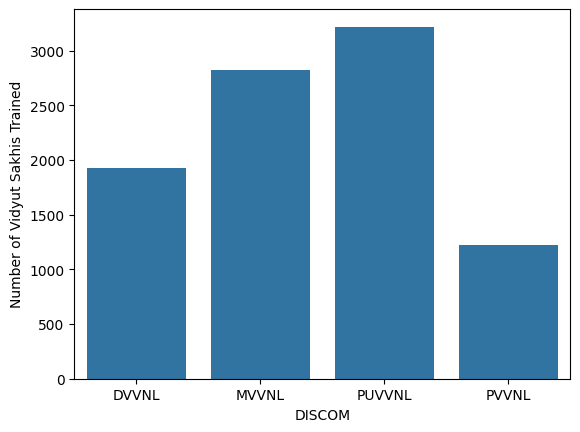

In [14]:
# Plotting variationin discom wise training 
sns.barplot(df_2.groupby('DISCOM')['Number of Vidyut Sakhis Trained'].sum())

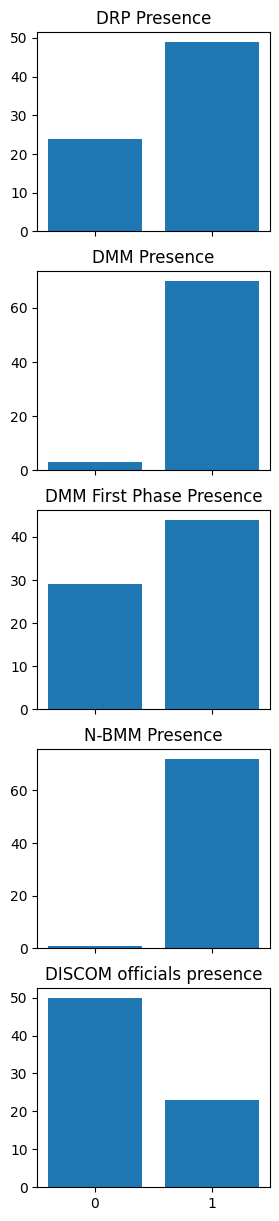

In [15]:
fig, axs = plt.subplots(nrows=5,ncols=1, figsize = (3,15), sharex=True)
axs[0].bar(x = df_2['DRP Presence'].value_counts().sort_index().index, height = df_2['DRP Presence'].value_counts().sort_index().values)
axs[0].set_title('DRP Presence')

axs[1].bar(x = df_2['DMM Presence'].value_counts().sort_index().index, height = df_2['DMM Presence'].value_counts().sort_index().values)
axs[1].set_title('DMM Presence')

axs[3].bar(x = df_2['N-BMM Presence'].value_counts().sort_index().index, height = df_2['N-BMM Presence'].value_counts().sort_index().values)
axs[3].set_title('N-BMM Presence')

axs[4].bar(x = df_2['DISCOM officials presence'].value_counts().sort_index().index, height = df_2['DISCOM officials presence'].value_counts().sort_index().values)
axs[4].set_title('DISCOM officials presence')

axs[2].bar(x = df_2['DMM First Phase Presence'].value_counts().sort_index().index, height = df_2['DMM First Phase Presence'].value_counts().sort_index().values)
axs[2].set_title('DMM First Phase Presence')
axs[2].set_xticks(ticks = [0,1])

plt.show()

# Analytical tests

In [124]:
merged_df[merged_df['batch'].isin(rm_batch_list)]

,batch,name,ph_no,district,A2_Q1_R/W,A2_Q2_R/W,A2_Q3_R/W,A2_Q4_R/W,A2_Q5_R/W,A2_Q6_R/W,A2_Q7_R/W,A2_Q1_Abs,A2_Q2_Abs,A2_Q3_Abs,A2_Q4_Abs,A2_Q5_Abs,A2_Q6_Abs,A2_Q7_Abs,A1_Q1_R/W,A1_Q2_R/W,A1_Q3_R/W,A1_Q4_R/W,A1_Q5_R/W,A1_Q6_R/W,A1_Q7_R/W,A1_Q1_Abs,A1_Q2_Abs,A1_Q3_Abs,A1_Q4_Abs,A1_Q5_Abs,A1_Q6_Abs,A1_Q7_Abs,day,month,year,date,total_A2,total_A1,A2_string,A1_string,num_vs_trained,drp_presence,dmm_presence,bmm_presence,discom_presence,dmm_ff_presence,commission_vs,avg_bill_amt,num_vs_working,Percent_Training Target Achieved,DISCOM,score_change
341,Ambedkar Nagar_10_12,vs_342,6391720435,ambedkar nagar,1,1,1,0,1,1,1,1,2,1,1,3,1,1,1,1,1,0,1,1,1,1,2,1,1,3,1,1,10,12,2024,2024-12-10,6,6,1211311,1211311,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL,0
342,Ambedkar Nagar_10_12,vs_343,7084181315,ambedkar nagar,1,1,1,0,1,1,1,1,2,1,1,3,1,1,1,1,1,0,1,1,1,1,2,1,1,3,1,1,10,12,2024,2024-12-10,6,6,1211311,1211311,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL,0
343,Ambedkar Nagar_10_12,vs_344,7310342181,ambedkar nagar,1,1,1,0,1,1,1,1,2,1,1,3,1,1,1,1,1,0,1,1,1,1,2,1,1,3,1,1,10,12,2024,2024-12-10,6,6,1211311,1211311,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL,0
344,Ambedkar Nagar_10_12,vs_345,7348726971,ambedkar nagar,1,1,1,0,1,1,1,1,2,1,1,3,1,1,1,1,1,0,1,1,1,1,2,1,1,3,1,1,10,12,2024,2024-12-10,6,6,1211311,1211311,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL,0
345,Ambedkar Nagar_10_12,vs_346,7379031013,ambedkar nagar,1,1,1,0,1,1,1,1,2,1,1,3,1,1,1,0,1,0,1,0,1,1,1,1,2,3,2,1,10,12,2024,2024-12-10,6,4,1211311,1112321,123,1,1,1,1,1,11755,1418,133,0.82,MVVNL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,Sitapur_19_12,vs_10005,8953712201,sitapur,1,1,1,1,1,1,1,1,2,1,3,3,1,1,0,0,0,0,0,0,0,4,4,4,4,4,4,4,19,12,2024,2024-12-19,7,0,1213311,4444444,113,1,1,1,1,0,5290,1173,118,0.64,MVVNL,7
9745,Sitapur_19_12,vs_10006,9236229180,sitapur,1,1,1,1,1,1,1,1,2,1,3,3,1,1,0,0,0,0,1,0,0,4,3,4,4,3,2,4,19,12,2024,2024-12-19,7,1,1213311,4344324,113,1,1,1,1,0,5290,1173,118,0.64,MVVNL,6
9746,Sitapur_19_12,vs_10007,9559645324,sitapur,1,1,1,1,1,1,1,1,2,1,3,3,1,1,0,0,0,0,0,0,0,4,4,4,4,4,4,4,19,12,2024,2024-12-19,7,0,1213311,4444444,113,1,1,1,1,0,5290,1173,118,0.64,MVVNL,7
9747,Sitapur_19_12,vs_10008,9569093099,sitapur,1,1,1,1,1,1,1,1,2,1,3,3,1,1,0,0,0,1,1,0,0,4,4,4,3,3,2,4,19,12,2024,2024-12-19,7,2,1213311,4443324,113,1,1,1,1,0,5290,1173,118,0.64,MVVNL,5


In [127]:
# Merging VS and district level data (Removes Hathras and Jalaun)
merged_df = pd.merge(left=df_1, right=df_2, how = 'inner', on = 'district')
merged_df['score_change'] = merged_df['total_A2'] - merged_df['total_A1']

# Removing data on batches with cheating
print(f"Number of datapoints removed: {merged_df['batch'].isin(rm_batch_list).sum()}")
merged_df = merged_df[~merged_df['batch'].isin(rm_batch_list)]

# Renaming columns
rename_dict = {'Number of Vidyut Sakhis Trained': 'num_vs_trained',
               'Commission/VS_INR': 'commission_vs',
               'Average Bill Amount_INR': 'avg_bill_amt',
               'Number of VS working': 'num_vs_working',
               'DRP Presence': 'drp_presence',
               'DMM Presence': 'dmm_presence',
               'DMM First Phase Presence': 'dmm_ff_presence',
               'N-BMM Presence': 'bmm_presence',
               'DISCOM officials presence': 'discom_presence'
               }
merged_df = merged_df.rename(mapper = rename_dict, axis = 1)

# Setting district and batch as indices
for id in ['district', 'batch']:
    le = LabelEncoder()
    merged_df[id] = le.fit_transform(merged_df[id])
merged_df = merged_df.set_index(['district', 'batch'])

Number of datapoints removed: 755


## T-test for difference in means

In [17]:
print( f'Average difference in post training score: {merged_df['score_change'].mean().round(2)}')

Average difference in post training score: 1.37


In [18]:
# T-test for difference in means
tstat, pvalue = ttest_rel(df_1['total_A1'], df_1['total_A2'])
print(f'pvalue: {pvalue.round(2)}')
print ('There is a statistically significant difference in pre and post training scores')

pvalue: 0.0
There is a statistically significant difference in pre and post training scores


# Average score in Aaklan-2 (grouped by Aaklan-1 scores)

In [128]:
display(merged_df.groupby('total_A1')['total_A2'].mean())
print("Average score has moved towards 5")

total_A1
0    4.987952
1    5.005755
2    4.831967
3    4.896700
4    4.962005
5    5.220213
6    5.651780
7    6.402730
Name: total_A2, dtype: float64

Average score has moved towards 5


## Checking impact due to individual variation

In [12]:
# Preparing data for panel data estimation
long_df = pd.wide_to_long(merged_df[['total_A1', 'total_A2','name']],
                          stubnames = 'total_A',
                          i = 'name',
                          j = 'time_period')
long_df = long_df.rename({'total_A':'score'}, axis = 1)
long_df['time'] = long_df.index.get_level_values(1)
long_df['time'] = long_df['time'].replace({1:0, 2:1})

In [13]:
long_df.head()

,,score,time
name,time_period,,
vs_1,1,5,0
vs_2,1,6,0
vs_3,1,2,0
vs_4,1,4,0
vs_5,1,5,0


In [ ]:
formula = 'score ~ 1 + time + EntityEffects'                            # Results are same without individual fixed effects. Implies that there are no major time-invariant characteristics between idividuals that explain improvement in scores
model = linearmodels.panel.model.PanelOLS.from_formula(formula=formula, data = long_df)
results = model.fit(cov_type="clustered", cluster_entity=True)
results

Dep. Variable:,score,R-squared:,0.3052
Estimator:,PanelOLS,R-squared (Between):,-2.22e-16
No. Observations:,20780,R-squared (Within):,0.3052
Date:,"Tue, Mar 25 2025",R-squared (Overall):,0.1476
Time:,10:42:59,Log-likelihood,-3.012e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,4562.9
Entities:,10390,P-value,0.0000
Avg Obs:,2.0000,Distribution:,"F(1,10389)"
Min Obs:,2.0000,,
Max Obs:,2.0000,F-statistic (robust):,4562.9


1. Trainings have a positive impact on scores, improving them by 1.36 (on average).
2. Value of time intercept is close to simple raw average. This implies that there are no individual level heterogenous impacts of training. Pre-existing differences in individuals did not affect training outcome.

## Checking impact of specific district level variables

In [ ]:
# Check which var has more variation:tot_a1, tot_a2, difference

### Without controlling for past scores

In [133]:
# Scaling numeric variables to improve model stability
trial = merged_df.copy()
for col in ['num_vs_trained', 'commission_vs', 'avg_bill_amt', 'num_vs_working']:
    scaler = StandardScaler()
    trial[col] = scaler.fit_transform(np.array(trial[col]).reshape(-1,1))

In [136]:
formula = 'total_A2 ~ num_vs_trained +  commission_vs + avg_bill_amt + num_vs_working + C(DISCOM) + drp_presence +  dmm_ff_presence + discom_presence'
model = smf.ols(formula=formula, data = trial)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_A2   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     64.24
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          3.26e-127
Time:                        16:41:25   Log-Likelihood:                -15576.
No. Observations:                9635   AIC:                         3.117e+04
Df Residuals:                    9624   BIC:                         3.125e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3655      0.042    127.702      0.000       5.283       5.448
C(DISCOM)[T.MVVNL]     -0.3527      0.041     -8.643      0.000      -0.433      -0.273
C(DISCOM)[T.PUVVNL]     0.0121      0.040      0.303      0.762      -0.066       0.091
C(DISCOM)[T.PVVNL]     -0.7032      0.054    -13.053      0.000      -0.809      -0.598
num_vs_trained         -0.0495      0.015     -3.346      0.001      -0.079      -0.021
commission_vs          -0.1150      0.014     -8.287      0.000      -0.142      -0.088
avg_bill_amt            0.0339      0.015      2.306      0.021       0.005       0.063
num_vs_working          0.1282      0.014      8.854      0.000       0.100       0.157
drp_presence           -0.0530      0.030     -1.775      0.076      -0.112       0.006
dmm_ff_presence        -0.0966      0.026     -3.692      0.000      -0.148      -0.045
discom_presence         0.4138      0.029     14.352      0.000       0.357       0.470
==============================================================================
Omnibus:                     1151.636   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1770.107
Skew:                          -0.865   Prob(JB):                         0.00
Kurtosis:                       4.189   Cond. No.                         9.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### With controlling for past score (on change in scores)

In [137]:
trial = merged_df.copy()
for col in ['num_vs_trained', 'commission_vs', 'avg_bill_amt', 'num_vs_working']:
    scaler = StandardScaler()
    trial[col] = scaler.fit_transform(np.array(trial[col]).reshape(-1,1))

In [138]:
formula = 'total_A2 ~ C(total_A1) + num_vs_trained +  commission_vs + avg_bill_amt + num_vs_working + C(DISCOM) + drp_presence +  dmm_ff_presence + discom_presence'
model = smf.ols(formula=formula, data = trial)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_A2   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     102.5
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:41:58   Log-Likelihood:                -15085.
No. Observations:                9635   AIC:                         3.021e+04
Df Residuals:                    9617   BIC:                         3.033e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.1858      0.057     91.177      0.000       5.074       5.297
C(total_A1)[T.1]        0.0496      0.063      0.787      0.432      -0.074       0.173
C(total_A1)[T.2]       -0.1112      0.059     -1.898      0.058      -0.226       0.004
C(total_A1)[T.3]       -0.0251      0.055     -0.455      0.649      -0.133       0.083
C(total_A1)[T.4]        0.0465      0.053      0.879      0.380      -0.057       0.150
C(total_A1)[T.5]        0.2858      0.053      5.381      0.000       0.182       0.390
C(total_A1)[T.6]        0.6688      0.055     12.243      0.000       0.562       0.776
C(total_A1)[T.7]        1.4109      0.066     21.245      0.000       1.281       1.541
C(DISCOM)[T.MVVNL]     -0.2936      0.039     -7.552      0.000      -0.370      -0.217
C(DISCOM)[T.PUVVNL]    -0.0205      0.038     -0.536      0.592      -0.095       0.054
C(DISCOM)[T.PVVNL]     -0.7249      0.051    -14.081      0.000      -0.826      -0.624
num_vs_trained         -0.0801      0.014     -5.665      0.000      -0.108      -0.052
commission_vs          -0.0843      0.013     -6.347      0.000      -0.110      -0.058
avg_bill_amt            0.0182      0.014      1.298      0.194      -0.009       0.046
num_vs_working          0.1404      0.014     10.177      0.000       0.113       0.167
drp_presence           -0.0598      0.029     -2.093      0.036      -0.116      -0.004
dmm_ff_presence        -0.1541      0.025     -6.145      0.000      -0.203      -0.105
discom_presence         0.3115      0.028     11.284      0.000       0.257       0.366
==============================================================================
Omnibus:                     1109.542   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1737.661
Skew:                          -0.829   Prob(JB):                         0.00
Kurtosis:                       4.256   Cond. No.                         17.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: 
* Past score explains a large part of variation in score change. People with low score in A1 saw the highest improvement.
* DMM and BMM have not been considered due to no variation.  
* Controlling for individual/batch/district fixed effects will absorb all the variation in the above variables. Therefore, the above model has been run without any FE. 
* Verify if the coeffs of the variables make sense. 

### With controlling for past score (on absolute A2 scores)

In [132]:
trial = merged_df.copy()
for col in ['num_vs_trained', 'commission_vs', 'avg_bill_amt', 'num_vs_working']:
    scaler = StandardScaler()
    trial[col] = scaler.fit_transform(np.array(trial[col]).reshape(-1,1))

In [16]:
formula = 'total_A2 ~ C(total_A1) + num_vs_trained +  commission_vs + avg_bill_amt + num_vs_working + C(DISCOM) + drp_presence +  dmm_ff_presence + discom_presence'
model = smf.ols(formula=formula, data = trial)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_A2   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     126.9
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:25:22   Log-Likelihood:                -16053.
No. Observations:               10390   AIC:                         3.214e+04
Df Residuals:                   10372   BIC:                         3.227e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3157      0.052    101.500      0.000       5.213       5.418
C(total_A1)[T.1]       -0.0949      0.058     -1.629      0.103      -0.209       0.019
C(total_A1)[T.2]       -0.2476      0.054     -4.555      0.000      -0.354      -0.141
C(total_A1)[T.3]       -0.1760      0.051     -3.445      0.001      -0.276      -0.076
C(total_A1)[T.4]       -0.1203      0.049     -2.459      0.014      -0.216      -0.024
C(total_A1)[T.5]        0.1223      0.049      2.497      0.013       0.026       0.218
C(total_A1)[T.6]        0.5064      0.050     10.171      0.000       0.409       0.604
C(total_A1)[T.7]        1.1935      0.061     19.692      0.000       1.075       1.312
C(DISCOM)[T.MVVNL]     -0.2590      0.037     -7.068      0.000      -0.331      -0.187
C(DISCOM)[T.PUVVNL]     0.0317      0.036      0.881      0.378      -0.039       0.102
C(DISCOM)[T.PVVNL]     -0.7095      0.048    -14.751      0.000      -0.804      -0.615
num_vs_trained         -0.0928      0.013     -6.931      0.000      -0.119      -0.067
commission_vs          -0.0781      0.012     -6.257      0.000      -0.103      -0.054
avg_bill_amt            0.0309      0.013      2.335      0.020       0.005       0.057
num_vs_working          0.1330      0.013     10.378      0.000       0.108       0.158
drp_presence           -0.0268      0.027     -0.985      0.325      -0.080       0.027
dmm_ff_presence        -0.1820      0.024     -7.709      0.000      -0.228      -0.136
discom_presence         0.3482      0.025     13.678      0.000       0.298       0.398
==============================================================================
Omnibus:                     1367.557   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2355.668
Skew:                          -0.882   Prob(JB):                         0.00
Kurtosis:                       4.526   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# DAG

In [72]:
df_model = merged_df.copy()
df_model['training_const'] = 1


In [78]:
causal_graph = '''
digraph {
training_const -> score_change;
total_A1 -> score_change;
num_vs_trained -> score_change; num_vs_trained -> training_const;
drp_presence -> score_change; drp_presence -> training_const; 
dmm_presence -> score_change; dmm_presence -> training_const; 
bmm_presence -> score_change; bmm_presence -> training_const; 
discom_presence -> score_change; discom_presence -> training_const;
dmm_ff_presence -> score_change; dmm_ff_presence -> training_const;
commission_vs -> total_A1; commission_vs -> score_change; commission_vs -> num_vs_working;
avg_bill_amt -> commission_vs; 
num_vs_working -> total_A1; num_vs_working -> score_change; num_vs_working -> num_vs_trained; 
DISCOM -> num_vs_trained; DISCOM -> dmm_presence; DISCOM -> bmm_presence; DISCOM -> discom_presence; DISCOM -> dmm_ff_presence; DISCOM -> commission_vs; DISCOM -> avg_bill_amt; DISCOM -> num_vs_working; DISCOM -> training_const; DISCOM -> score_change
} 
'''

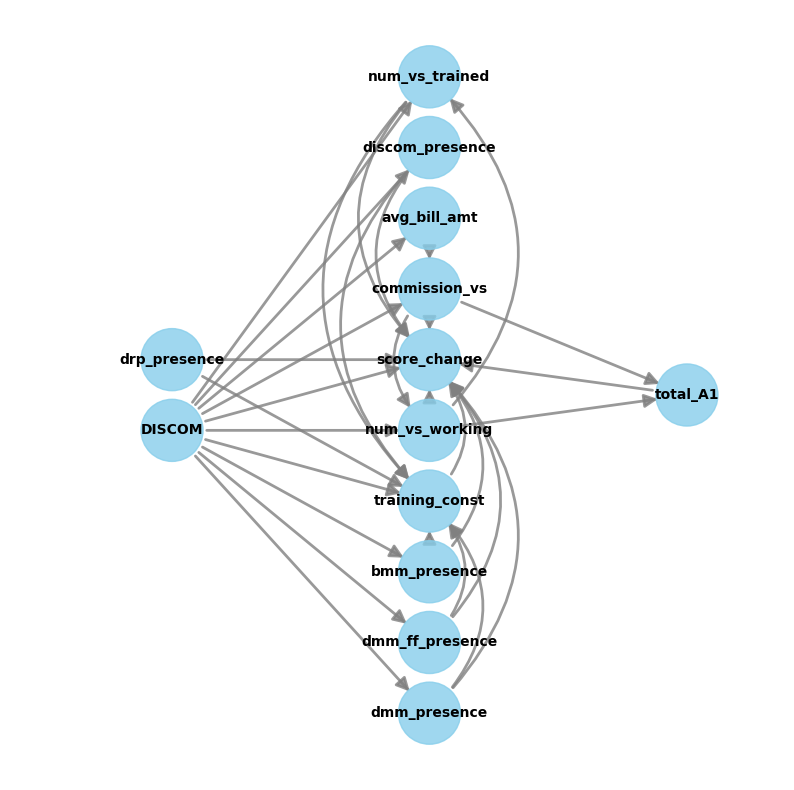

In [81]:
model = dowhy.CausalModel(data = df_model,
                          graph = causal_graph,
                          treatment= 'training_const',
                          outcome='score_change')
model.view_model(size = (10,10))

In [82]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print (estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                      ↪
─────────────────(E[score_change|dmm_presence,bmm_presence,drp_presence,dmm_ff ↪
d[training_const]                                                              ↪

↪                                                  
↪ _presence,DISCOM,discom_presence,num_vs_trained])
↪                                                  
Estimand assumption 1, Unconfoundedness: If U→{training_const} and U→score_change then P(score_change|training_const,dmm_presence,bmm_presence,drp_presence,dmm_ff_presence,DISCOM,discom_presence,num_vs_trained,U) = P(score_change|training_const,dmm_presence,bmm_presence,drp_presence,dmm_ff_presence,DISCOM,discom_presence,num_vs_trained)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [85]:
# Changing formulation to avoid controlling for mediators and colliders doent change the direction
formula = 'score_change ~ num_vs_trained + C(DISCOM) + drp_presence +  dmm_ff_presence + discom_presence'
model = smf.ols(formula=formula, data = trial)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score_change   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     89.40
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          5.09e-127
Time:                        13:50:35   Log-Likelihood:                -21957.
No. Observations:               10390   AIC:                         4.393e+04
Df Residuals:                   10382   BIC:                         4.399e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2048      0.063     35.173      0.000       2.082       2.328
C(DISCOM)[T.MVVNL]     -0.0323      0.059     -0.548      0.584      -0.148       0.083
C(DISCOM)[T.PUVVNL]    -0.2065      0.060     -3.445      0.001      -0.324      -0.089
C(DISCOM)[T.PVVNL]     -1.2353      0.071    -17.449      0.000      -1.374      -1.097
num_vs_trained         -0.0511      0.023     -2.232      0.026      -0.096      -0.006
drp_presence           -0.2224      0.046     -4.839      0.000      -0.312      -0.132
dmm_ff_presence        -0.7353      0.041    -17.895      0.000      -0.816      -0.655
discom_presence         0.0505      0.044      1.158      0.247      -0.035       0.136
==============================================================================
Omnibus:                      448.041   Durbin-Watson:                   1.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.237
Skew:                           0.540   Prob(JB):                    7.16e-111
Kurtosis:                       2.921   Cond. No.                         8.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""